# Feature Extractor Code 

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

# Setting seeds for reproducibility.
SEED = 42
keras.utils.set_random_seed(SEED)

2025-03-13 14:45:36.665176: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 14:45:36.674664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741887936.687087 3139219 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741887936.690455 3139219 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 14:45:36.705438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
from mae_code import *

In [3]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4


# PRETRAINING
EPOCHS = 100


## Load data


In [4]:
import os
import tensorflow as tf



base_dir = 'png_512'

# Create a dataset from images in the directory
dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir),              # Base directory
    labels='inferred',                   # Infer labels from directory structure
    color_mode="grayscale",
    label_mode=None,                     # No labels
    image_size=(IMAGE_SIZE, IMAGE_SIZE), # Image size
    batch_size=BATCH_SIZE,               # Batch size
    shuffle=False,                       # Do not shuffle the data
    interpolation='bilinear'
)




Found 70684 files.


W0000 00:00:1741887940.155220 3139219 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Functions

These functions are identical to those used in the pre-training code.


In [5]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
#             layers.RandomFlip("horizontal"),
#             layers.RandomRotation(factor=0.15),  # Rotação aleatória entre -30 e 30 graus (fator = 0.15 para 15 graus)
         layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0),
         layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

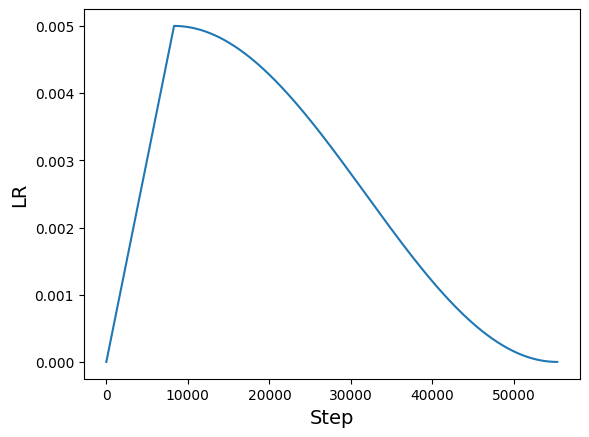

In [6]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(dataset)) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()


## Load Weights from Pre-trained Models

In [7]:
# instantiate the models

train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

optimizer = tf.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

#Compile and pretrain the model.
model.compile( optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"])

In [ ]:

check_point = "pre-trained-models/mp75/"

# Criando o checkpoint para restaurar
checkpoint = tf.train.Checkpoint(
    patch_encoder=model.patch_encoder,
    encoder=model.encoder,
    decoder=model.decoder
)

# Defina o diretório onde o checkpoint foi salvo
checkpoint_directory = check_point + 'mae_model/'

# Verifique se o checkpoint existe e faça a restauração
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_directory)

if latest_checkpoint:
    checkpoint.restore(latest_checkpoint).expect_partial()
    print("Checkpoint restored successfully!")
else:
    print("No checkpoint found.")

Checkpoint restaurado com sucesso!


## Visualizing the Reconstruction

In [9]:
images = next(iter(dataset))

augmented_images = test_augmentation_model(images)

In [10]:

import matplotlib.pyplot as plt

def visualize_results(model, augmented_images):

    # Patch the augmented images.
    patches = model.patch_layer(augmented_images)

    # Encode the patches.
    (
        unmasked_embeddings,
        masked_embeddings,
        unmasked_positions,
        mask_indices,
        unmask_indices,
    ) = model.patch_encoder(patches)

    # Pass the unmasked patches to the encoder.
    encoder_outputs = model.encoder(unmasked_embeddings)

    # Create the decoder inputs.
    encoder_outputs = encoder_outputs + unmasked_positions
    decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
    decoder_outputs = model.decoder(decoder_inputs)

    # Show a masked patch image.
    masked_patches = model.patch_encoder.generate_masked_images(
        patches[2:6], unmask_indices[2:6], color = 0.3
)

    masked_images = []
    for masked_patch in masked_patches:
        # Apply the reconstruction function to the masked patch
        masked_image = model.patch_layer.reconstruct_from_patch(masked_patch)
        masked_images.append(masked_image)

    original_image = augmented_images[2:6]
    reconstructed_image = decoder_outputs[2:6]

    # Minimalistic plot settings
    fig, ax = plt.subplots(4, 3, figsize=(7.5, 10))
    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    for i in range(4):
        # Original
        ax[i, 0].imshow(original_image[i], cmap='gray')
        ax[i, 0].axis('off')

        # Masked
        ax[i, 1].imshow(masked_images[i], cmap='gray')
        ax[i, 1].axis('off')

        # Reconstruída
        ax[i, 2].imshow(reconstructed_image[i], cmap='gray')
        ax[i, 2].axis('off')

        if i == 0:
          ax[i, 0].set_title("Original")
          ax[i, 1].set_title("Masked")
          ax[i, 2].set_title("Reconstructed")

    plt.show()

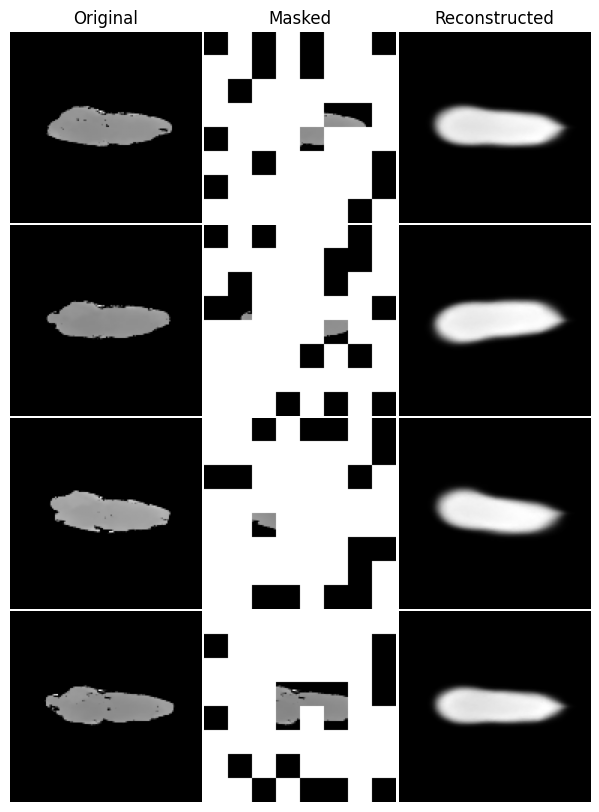

In [11]:

# augmented_images = test_augmentation_model(images)
visualize_results(model, augmented_images)

## Extracting Latent Variables

In [15]:
import tensorflow as tf
from tqdm import tqdm

# Assuming you have a train_dataset containing multiple images

# Initialize an empty list to store the results for each image
processed_images = []

# Use tqdm to create a progress bar for the loop
for images in tqdm(dataset, total=len(dataset)):
    # Perform the same operations as in your code snippet

    # Apply augmentation to the image
    augmented_images = test_augmentation_model(images)

    # Patch the augmented images
    patches = patch_layer(augmented_images)

    # Encode the patches
    (
        unmasked_embeddings,
        masked_embeddings,
        unmasked_positions,
        mask_indices,
        unmask_indices,
    ) = model.patch_encoder(patches)

    # Pass the unmasked patches to the encoder
    encoder_outputs = model.encoder(unmasked_embeddings)

    # Append the processed image to the list
    processed_images.append(encoder_outputs)

# processed_images now contains the processed data for the entire dataset, and you will see a progress bar as the loop iterates.


100%|██████████| 553/553 [00:45<00:00, 12.22it/s]


## Reshaping

In [ ]:
# Initialize a new list to store the reshaped tensors
reshaped_outputs = []

# Use tqdm to create a progress bar for the loop
for output in tqdm(processed_images, total=len(processed_images), desc="Reshaping"):
    reshaped_tensor = tf.reshape(output, [output.shape[0], 32* 16])
    reshaped_outputs.append(reshaped_tensor)

Reshaping:   0%|          | 0/553 [00:00<?, ?it/s]


InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 32768 values, but the requested shape has 98304 [Op:Reshape]

In [ ]:


# Assuming reshaped_outputs is a list of shape (553, 128, 768)

# Convert the list to a NumPy array
reshaped_array = np.array(reshaped_outputs[:-1])

# Reshape the array to have shape (553*128, 768)
reshaped_array = reshaped_array.reshape(-1, 512)

# Create a DataFrame from the reshaped array
df = pd.DataFrame(reshaped_array)


In [ ]:
a = df.iloc[23]
a = np.array(a)
a = a.reshape(1,32,16)
a = tf.convert_to_tensor(a)

# # Create the decoder inputs.
encoder_outputs = a + unmasked_positions
decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
decoder_outputs = model.decoder(decoder_inputs)


original_image = augmented_images[0]
reconstructed_image = decoder_outputs[0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(original_image, cmap = 'gray')
ax[0].set_title("Original:")

ax[1].imshow(reconstructed_image, cmap = 'gray')
ax[1].set_title("Resonstructed:")

plt.show()
plt.close()

InvalidArgumentError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [1,32,16] vs. [28,16,16] [Op:AddV2] name: 

In [ ]:
# Append the last batch with size 28
last_batch = reshaped_outputs[-1]  # Assuming the last element is the last batch
last_batch = last_batch[:28]  # Keep only the first 28 elements
last_batch = np.array(last_batch)

# Append the last batch to the DataFrame
df = df.append(pd.DataFrame(last_batch), ignore_index=True)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,2.919363,-1.669769,0.692077,0.830076,-1.659853,0.111276,-0.237923,-2.141848,-0.442302,-0.342038,...,0.249392,-1.605653,-1.078064,-1.610655,-1.718846,0.421101,-2.694560,1.265672,1.081484,2.185368
1,0.888674,-1.636093,-3.402671,1.935414,-0.229169,2.447495,0.213846,-2.252254,-1.492656,3.091881,...,-0.241138,-1.501706,-0.952623,-0.607781,-0.040614,-0.769011,-2.778710,3.116666,0.341036,1.264293
2,3.891949,-3.220488,-1.118621,1.380225,1.179852,1.601483,0.364860,-3.990330,-1.535794,-1.854613,...,0.125863,-2.847452,-0.789337,-0.925192,0.343257,-0.186160,-3.352988,0.855913,-0.118125,-0.138036
3,3.446969,-0.064171,-2.262740,0.345461,2.401844,0.146445,1.400088,-2.909817,-2.106238,-1.136811,...,1.535466,-3.113738,-0.579717,-1.287840,-0.895918,-0.275327,-2.095167,-1.023440,0.827415,-0.625081
4,2.222681,-1.329499,-2.856633,3.985693,-2.392944,1.805915,0.598616,-0.951461,-1.138486,-1.559314,...,1.722368,-1.700150,-0.727134,-0.259903,-2.163040,0.236748,-0.758186,-1.591737,0.637878,-0.834662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35323,3.902381,0.236763,-0.698263,2.019784,0.337826,0.343013,0.535201,-1.341204,0.320892,-1.999586,...,0.714978,-4.657207,-2.390652,0.859175,0.333692,2.513768,0.183077,2.132719,-0.710044,-0.749938
35324,2.264624,-1.878903,-3.657181,2.048610,-0.856875,2.003016,-0.418253,-3.663642,-1.536171,1.953960,...,0.364567,-4.848113,-2.681099,2.726894,0.111392,2.248328,0.016255,0.992371,-0.800181,-0.774167
35325,2.931981,-1.783965,0.364712,2.107284,-0.681912,-0.855348,-0.030395,-1.451763,-0.077196,-1.026734,...,0.755534,-2.682415,-0.060453,-3.281865,-0.274081,-0.251488,-1.624794,-0.472010,-0.950113,-0.274965
35326,5.266166,-0.892147,-0.678901,0.208902,2.160932,1.489217,-0.154762,-3.814254,-1.528633,0.290677,...,0.191023,0.527912,0.530646,-2.910731,-0.463829,-1.831557,-2.385628,2.413481,-0.397143,0.823369


In [ ]:
all_files = [filename for filename in os.listdir('png_512') if filename.endswith('.png')]
len(all_files)

70684

In [ ]:

# Remove "resultado_" prefix and ".png" suffix from all elements in the list
cleaned_list = [filename.replace('resultado_', '').replace('.png', '') for filename in all_files]


cleaned_list = sorted(cleaned_list)


In [ ]:
df['Filenames'] = cleaned_list

35328

In [ ]:
#df.to_csv('/content/drive/My Drive/Colab Notebooks/tc/resultados/output_dim16_mp50.csv', index=False)